# CMIP6 models C${_3}$ & C${_4}$ vegetation variables analysis

This script is written in such a way that it can be used to process C3 and C4 vegetattion variables: Area, GPP, carbon content in vegetatin (cVeg) and land (cLand). Here, it is used for the vegetation carbon content. It takes the needed and available variables, calculate the C3 and C4 natural and crop components and their respective total.

## Load the needed data

In [2]:
#IMPORT NEEDED LIBRARIES
import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import os
from pyrealm import pmodel
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
from matplotlib.dates import date2num

In [25]:
cd Scripts/

/Users/jo122/CMIP6/Scripts


## Create a function to process the vegetation carbon content

In [13]:
#CREATE A FUNCTION TO CONVERT NUMPY ARRAY TO XARRAY DATASET
def convert_to_xarray(a, start_date="1850-01-01", periods=1980, 
                      lat_range=(-90, 90), lon_range=(0, 360), freq="ME"):
    """
    Convert a 3D NumPy array to xarray DataArray with specified dimensions and coordinates.
    
    Parameters:
        crpc3_gpp (np.ndarray): 3D NumPy array to convert.
        start_date (str): Start date for the time coordinate.
        periods (int): Number of periods for the time coordinate.
        lat_range (tuple): Latitude range as (min, max).
        lon_range (tuple): Longitude range as (min, max).
        freq (str): Frequency of the time coordinate.
    
    Returns:
        xr.DataArray: The resulting xarray DataArray.
    """
    # Create the time coordinate
    time = pd.date_range(start=start_date, periods=periods, freq=freq)
    
    # Create the latitude and longitude coordinates
    lat = np.linspace(lat_range[0], lat_range[1], num=a.shape[1])
    lon = np.linspace(lon_range[0], lon_range[1], num=a.shape[2])
    
    # Create the DataArray
    a1 = xr.DataArray(a, dims=("time", "lat", "lon"),
                      coords={"time": time, "lat": lat, "lon": lon})
    
    return a1


def process_carbon_data(x, y, z):
    """
    Process carbon data with the specified steps.

    Parameters:
    x: vegetation component data.
    y: Total vegetation carbon content known as cVeg
    z: total vegetation carbon content multiplying area and land.

    Returns:
    xarray.Dataset: Resampled annual values from step b.
    """
    # a. Multiply x with y and divide by 100
    step_a = (x * y)/100
    
    #Convert the value to xarray dataset
    step_a1 = convert_to_xarray(step_a)

    # b. Resample step_a into annual values
    step_b = step_a1.resample(time='YE').mean()

    # c. Multiply x with z
    step_c = x * z
    
    
    #Convert the value to xarray dataset
    step_c1 = convert_to_xarray(step_c)
    
    # d. Resample step_c for annual values and sum across the globe
    step_d = step_c1.resample(time='YE').mean().sum(dim=('lat', 'lon'))

    # e. Calculate the difference between each successive year from step_d
    step_e = step_d.diff(dim='time')

    # f. Return the values from step b as an xarray dataset
    dataset = step_b.to_dataset(name='carbon_content')

    # g. Create a DataFrame with the year as the index and the answers from d and e as columns
    years = step_d['time.year'].values
    df = pd.DataFrame({
        'Year': years,  
        'Carbon_Content': step_d.values,  #  Insert NaN for the first difference
        'Carbon_Accumulation': np.insert(step_e.values, 0, np.nan)
    })
    df.set_index('Year', inplace=True)

    return dataset, df

# Process models with similar available data

## ACCESS-ESM1.5, CMCC-ESM2 & CMCC-ESM2

In [7]:
# Load data
cveg = xr.open_dataset("cVeg_Lmon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
crp = xr.open_dataset("cropFrac_Lmon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
c3f = xr.open_dataset("c3PftFrac_Lmon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
c4f = xr.open_dataset("c4PftFrac_Lmon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
c3cr = xr.open_dataset("cropFracC3_Emon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
gca = xr.open_dataset("areacella_fx_CMCC-ESM2_piControl_r1i1p1f1_gn.nc", 
                       decode_times = True)
lnd = xr.open_dataset("sftlf_fx_CMCC-ESM2_piControl_r1i1p1f1_gn.nc", decode_times = True)

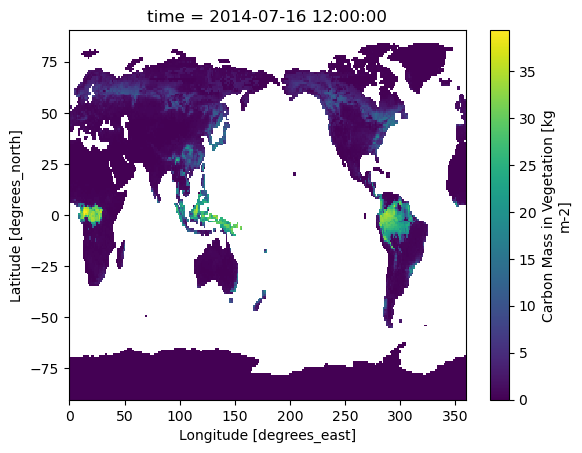

In [27]:
cveg['cVeg'][-6].plot()

In [8]:
#Extract the data variables
lnd1 = lnd.sftlf
gca1 = gca.areacella
cveg1 = cveg.cVeg
c3f1 = c3f.c3PftFrac
crp1 = crp.cropFrac
c4f1 = c4f.c4PftFrac
c3cr1 = c3cr.cropFracC3

In [9]:
#Convert numpy array
cveg2 = np.asarray(cveg1)
c3f2 = np.asarray(c3f1)
c4f2 = np.asarray(c4f1)
crp2 = np.asarray(crp1)
c3cr2 = np.asarray(c3cr1)
c4cr2 = crp2-c3cr2
c3nat = c3f2-c3cr2
c4nat = c4f2-c4cr2
totnat = c3nat+c4nat
gca2 = np.repeat(gca1.values[np.newaxis, ...],1980, axis = 0)
lnd2 = np.repeat(lnd1.values[np.newaxis, ...],1980, axis = 0) 

# CALL THE FUNCTION

The following cell was run for each model to process its variable. The occasional differences among the models' available variable are handled in the cell for data extraction and the cell for converting the xarray dataset to numpy arrays and the corresponding variable for each model is pass to the function.

In [19]:
#CALL THE FUNCTION

#Load variable
y = cveg2
z = cveg2 * lnd2 * gca2 * 10**(-2)

# Crops
dataset_crp, df_crp = process_carbon_data(crp2, y, z)

# Total
dataset_tot, df_tot = process_carbon_data(100, y, z)

# C3 Fraction
dataset_c3f, df_c3f = process_carbon_data(c3f2, y, z)

# C4 Fraction
dataset_c4f, df_c4f = process_carbon_data(c4f2, y, z)

#C3_Crop
dataset_c3cr, df_c3cr = process_carbon_data(c3cr2, y, z)

#C4_Crop
dataset_c4cr, df_c4cr = process_carbon_data(c4cr2, y, z)

#C3_Nat
dataset_c3nat, df_c3nat = process_carbon_data(c3nat, y, z)

#C4_Nat
dataset_c4nat, df_c4nat = process_carbon_data(c4nat, y, z)

#Nat_tot
dataset_totnat, df_totnat = process_carbon_data(totnat, y, z)


#Giving names to the datasets 
C3f2 = xr.Dataset({"C3f": dataset_c3f['carbon_content']})
C4f2 = xr.Dataset({"C4f": dataset_c4f['carbon_content']})
Crp2 = xr.Dataset({"Crp": dataset_crp['carbon_content']})
C3crp2 = xr.Dataset({"C3crp": dataset_c3cr['carbon_content']})
C4crp2 = xr.Dataset({"C4crp": dataset_c4cr['carbon_content']})
C3nat1 = xr.Dataset({"C3nat": dataset_c3nat['carbon_content']})
C4nat1 = xr.Dataset({"C4nat": dataset_c4nat['carbon_content']})
Totnat1 = xr.Dataset({"Totnat": dataset_c4nat['carbon_content']})
Total = xr.Dataset({"Total": dataset_totnat['carbon_content']})

#Merge the datasets 
cmes_cVeg = xr.merge([C3f2, C4f2, Crp2, C3crp2, C4crp2, C3nat1,
                      C4nat1, Totnat1, Total], compat = 'override')

#Add attributes
cmes_cVeg.attrs["Description"] = "MPI-ESM1-2-LR vegetations fractions carbon content from 1850 to 2014"
cmes_cVeg.attrs["Author"] = "Joseph Ovwemuvwose"
cmes_cVeg.attrs["Unit"] = "Vegetating carbon content-cVeg [kgm$^{-2}$]"
cmes_cVeg.attrs["Source of data"]="These values are calculated from its cVeg, C3, C4, CropFrac, areacella & sftlf"
cmes_cVeg.attrs["Date created"] = "31/07/2024"
cmes_cVeg.attrs["Data Primary source"] = "https://esgf-node.llnl.gov/search/cmip6/"

#Save them
#cmes_cVeg.to_netcdf('cmes_cVeg_1850_2014.nc')

# Rename columns
df_c3f.rename(columns={'Carbon_Content': 'C3_Carbon_Content', 'Carbon_Accumulation': 'C3_Carbon_Accumulation'},
              inplace=True)

df_c4f.rename(columns={'Carbon_Content': 'C4_Carbon_Content', 'Carbon_Accumulation': 'C4_Carbon_Accumulation'},
              inplace=True)

df_crp.rename(columns={'Carbon_Content': 'Crp_Carbon_Content', 'Carbon_Accumulation': 'Crp_Carbon_Accumulation'},
              inplace=True)

df_c3cr.rename(columns={'Carbon_Content': 'C3crp_Carbon_Content', 'Carbon_Accumulation': 'C3crp_Carbon_Accumulation'},
              inplace=True)

df_c4cr.rename(columns={'Carbon_Content': 'C4crp_Carbon_Content', 'Carbon_Accumulation': 'C4crp_Carbon_Accumulation'},
              inplace=True)

df_c3nat.rename(columns={'Carbon_Content': 'C3nat_Carbon_Content', 'Carbon_Accumulation': 'C3nat_Carbon_Accumulation'},
              inplace=True)

df_c4nat.rename(columns={'Carbon_Content': 'C4nat_Carbon_Content', 'Carbon_Accumulation': 'C4nat_Carbon_Accumulation'},
              inplace=True)

df_totnat.rename(columns={'Carbon_Content': 'Totnat_Carbon_Content', 'Carbon_Accumulation': 'Totnat_Carbon_Accumulation'},
              inplace=True)

df_tot.rename(columns={'Carbon_Content': 'Tot_Carbon_Content', 'Carbon_Accumulation': 'Tot_Carbon_Accumulation'},
              inplace=True)

#Combine them into one dataframe 
cmes_df1 = pd.concat([df_c3f, df_c4f, df_crp, df_c3cr, df_c4cr, df_c3nat, 
                     df_c4nat, df_totnat, df_tot], axis = 1)

#Save them as CSV 
#cmes_df1.to_csv('cmes_carbon_content_accumulation_1850_2014.csv', index = True)

In [20]:
# Check
cmes_cVeg

<xarray.Dataset> Size: 328MB
Dimensions:  (lat: 192, lon: 288, time: 165)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.254 2.509 3.763 ... 356.2 357.5 358.7 360.0
  * time     (time) datetime64[ns] 1kB 1850-12-31 1851-12-31 ... 2014-12-31
Data variables:
    C3f      (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
    C4f      (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
    Crp      (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
    C3crp    (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
    C4crp    (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
    C3nat    (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
    C4nat    (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
    Totnat   (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
    Total    (time, lat, lon) float32 36MB nan nan nan nan ... nan nan nan nan
Attributes:
    Description:          MPI-ESM1-2-LR vegetations fractions carbon content ...
    Author:               Joseph Ovwemuvwose
    Unit:                 Vegetating carbon content-cVeg [kgm$^{-2}$]
    Source of data:       These values are calculated from its cVeg, C3, C4, ...
    Date created:         31/07/2024
    Data Primary source:  https://esgf-node.llnl.gov/search/cmip6/

In [21]:
cmes_df1.head(3)

,C3_Carbon_Content,C3_Carbon_Accumulation,C4_Carbon_Content,C4_Carbon_Accumulation,Crp_Carbon_Content,Crp_Carbon_Accumulation,C3crp_Carbon_Content,C3crp_Carbon_Accumulation,C4crp_Carbon_Content,C4crp_Carbon_Accumulation,C3nat_Carbon_Content,C3nat_Carbon_Accumulation,C4nat_Carbon_Content,C4nat_Carbon_Accumulation,Totnat_Carbon_Content,Totnat_Carbon_Accumulation,Tot_Carbon_Content,Tot_Carbon_Accumulation
Year,,,,,,,,,,,,,,,,,,
1850,3.504091e+16,NaN,2.662046e+15,NaN,1.200888e+15,NaN,1.200888e+15,NaN,0.0,NaN,3.384002e+16,NaN,2.662046e+15,NaN,3.650206e+16,NaN,3.896853e+16,NaN
1851,3.501680e+16,-2.410765e+13,2.651378e+15,-1.066843e+13,1.203792e+15,2.904337e+12,1.203792e+15,2.904337e+12,0.0,0.0,3.381301e+16,-2.701105e+13,2.651378e+15,-1.066843e+13,3.646438e+16,-3.767975e+13,3.893011e+16,-3.841848e+13
1852,3.514148e+16,1.246872e+14,2.698033e+15,4.665516e+13,1.234477e+15,3.068432e+13,1.234477e+15,3.068432e+13,0.0,0.0,3.390701e+16,9.400395e+13,2.698033e+15,4.665516e+13,3.660504e+16,1.406559e+14,3.910073e+16,1.706219e+14


## CanESM5

In [1014]:
# Load data
cveg = xr.open_dataset("cVeg_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
crp = xr.open_dataset("cropFrac_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
c3f = xr.open_dataset("c3PftFrac_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
c4f = xr.open_dataset("c4PftFrac_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
c3cr = xr.open_dataset("cropFracC3_Emon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
c4cr = xr.open_dataset("cropFracC4_Emon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc", 
                       decode_times = True)
gca = xr.open_dataset("areacella_fx_CanESM5_piControl_r1i1p1f1_gn.nc", 
                       decode_times = True)
lnd = xr.open_dataset("sftlf_fx_CanESM5_piControl_r1i1p1f1_gn.nc", decode_times = True)

In [1015]:
#Extract the data variables
lnd1 = lnd.sftlf
gca1 = gca.areacella
cveg1 = cveg.cVeg
c3f1 = c3f.c3PftFrac
crp1 = crp.cropFrac
c4f1 = c4f.c4PftFrac
c3cr1 = c3cr.cropFracC3
c4cr1 = c4cr.cropFracC4

In [1016]:
#Convert to numpy array
c3f2 = np.asarray(c3f1)
c4f2 = np.asarray(c4f1)
crp2 = np.asarray(crp1)
c3cr2 = np.asarray(c3cr1)
c4cr2 = np.asarray(c4cr1)
cveg2 = np.asarray(cveg1)
c3nat = c3f2-c3cr2
c4nat = c4f2-c4cr2
totnat = c3nat+c4nat
gca2 = np.repeat(gca1.values[np.newaxis, ...],1980, axis = 0)
lnd2 = np.repeat(lnd1.values[np.newaxis, ...],1980, axis = 0) 

In [1023]:
cd ..

/Users/jo122/CMIP6/Data_CMIP6_model_output/CMIP6_models


##  CESM2, CESM2-WACCM & CNRM-CM6.1

In [1024]:
cd CESM2/

/Users/jo122/CMIP6/Data_CMIP6_model_output/CMIP6_models/CESM2


In [1070]:
# Load data
cveg = xr.open_dataset("cVeg_Lmon_CNRM-ESM2-1_historical_r1i1p1f2_gr_185001-201412.nc", 
                       decode_times = True)
crp = xr.open_dataset("cropFrac_Lmon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412.nc", 
                       decode_times = True)
c3f = xr.open_dataset("c3PftFrac_Lmon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412.nc", 
                       decode_times = True)
c4f = xr.open_dataset("c4PftFrac_Lmon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412.nc", 
                       decode_times = True)
gca = xr.open_dataset("areacella_fx_CNRM-CM6-1_historical_r1i1p1f2_gr.nc", 
                       decode_times = True)
lnd = xr.open_dataset("sftlf_fx_CNRM-CM6-1_historical_r1i1p1f2_gr.nc", decode_times = True)

In [1071]:
#Extract the data variables
lnd1 = lnd.sftlf
gca1 = gca.areacella
cveg1 = cveg.cVeg
c3f1 = c3f.c3PftFrac
crp1 = crp.cropFrac
c4f1 = c4f.c4PftFrac

In [1072]:
cveg2 = np.asarray(cveg1)
c3f2 = np.asarray(c3f1)
c4f2 = np.asarray(c4f1)
crp2 = np.asarray(crp1)
c3cr2 = crp1*c3f2/100
c4cr2 = crp1*c4f2/100
c3nat = c3f2-c3cr2
c4nat = c4f2-c4cr2
totnat = c3nat+c4nat
gca2 = np.repeat(gca1.values[np.newaxis, ...],1980, axis = 0)
lnd2 = np.repeat(lnd1.values[np.newaxis, ...],1980, axis = 0) 

## MPI-ESM-1-2-HAM, MPI-ESM1-2-LR & UKESM1

In [1121]:
#SECTION 1: LOAD THE DATA FOR EACH MODEL

#LOAD THE DATA by using CD to ento each individual folder for each model.
c3f = xr.open_mfdataset('c3PftFrac/*.nc', decode_times = True)
c4f = xr.open_mfdataset('c4PftFrac/*.nc', decode_times = True)
crp = xr.open_mfdataset('cropFrac/*.nc', decode_times = True)
c3cr = xr.open_mfdataset('cropFracC3/*', decode_times = True)
c4cr = xr.open_mfdataset('cropFracC4/*.nc', 
                        decode_times = True)
lnd = xr.open_dataset('sftlf_fx_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn.nc', decode_times = True)
gca = xr.open_dataset('areacella_fx_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn.nc', decode_times = True)
cveg = xr.open_mfdataset('cVeg/*.nc', decode_times = True)

In [1122]:
#Extract the data variables
lnd1 = lnd.sftlf
gca1 = gca.areacella
cveg1 = cveg.cVeg
c3f1 = c3f.c3PftFrac
crp1 = crp.cropFrac
c4f1 = c4f.c4PftFrac
c3cr1 = c3cr.cropFracC3
c4cr1 = c4cr.cropFracC4

In [1123]:
#Convert numpy array
c3f2 = np.asarray(c3f1)
c4f2 = np.asarray(c4f1)
crp2 = np.asarray(crp1)
c3cr2 = np.asarray(c3cr1)
c4cr2 = np.asarray(c4cr1)
cveg2 = np.asarray(cveg1)
c3nat = c3f2-c3cr2
c4nat = c4f2-c4cr2
totnat = c3nat+c4nat
gca2 = np.repeat(gca1.values[np.newaxis, ...],1980, axis = 0)
lnd2 = np.repeat(lnd1.values[np.newaxis, ...],1980, axis = 0) 

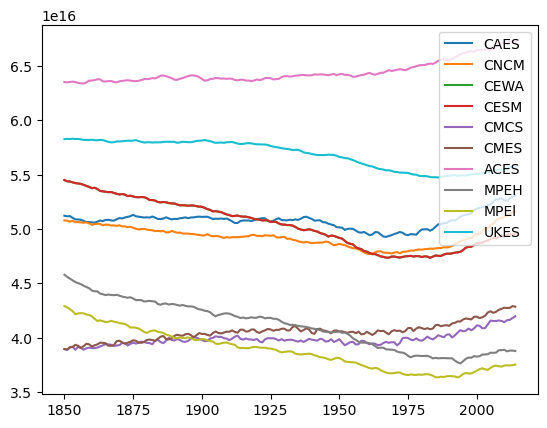

In [558]:
plt.plot(caes_df1.index,caes_df1['Tot_Carbon_Content'], label="CAES")
plt.plot(cncm_df1.index,cncm_df1['Tot_Carbon_Content'], label="CNCM")
plt.plot(cewa_df1.index,cewa_df1['Tot_Carbon_Content'], label="CEWA")
plt.plot(cesm_df1.index,cesm_df1['Tot_Carbon_Content'], label="CESM")
plt.plot(cmcs_df1.index,cmcs_df1['Tot_Carbon_Content'], label="CMCS")
plt.plot(cmes_df1.index,cmes_df1['Tot_Carbon_Content'], label="CMES")
plt.plot(aces_df1.index,aces_df1['Tot_Carbon_Content'], label="ACES")
plt.plot(mpeh_df1.index,mpeh_df1['Tot_Carbon_Content'], label="MPEH")
plt.plot(mpel_df1.index,mpel_df1['Tot_Carbon_Content'], label="MPEl")
plt.plot(ukes_df1.index,ukes_df1['Tot_Carbon_Content'], label="UKES")

plt.legend()